# Understanding the *UHCW* dataset
The [University Hospitals - Coventry & Warwickshire](https://www.uhcw.nhs.uk) (UHCW) has set up an online [portal](https://www.swiftqueue.co.uk/uhcw.php) to facilitate the booking of blood tests appointments in 18 centers around Coventry (UK).  


Available appointments have been recorded in the dataset `appointments.csv`. 
In this notebook we take a first look at this dataset.  

For speed and since this is still preliminary work, this notebook uses a relatively smaller subset, `sample_appointments.csv`.

---

## Summary of findings
- There are:
 - 18 test centers,
 - serving 2 age groups ("adult" and "child"),
 - delivering a total of 5 different test types, labeled:
   - 'Blood Test'
   - 'INR Test',
   - 'Fasting Bloods',
   - 'Non Fasting Bloods',
   - 'Glucose Tolerance Test'
- Each test center serves only 1 age group.
- Each center delivers 1, 2, or 3 different types of test.
- The centers open their appointments for booking with a varying number of days ahead of time, between 52 and 125.
- Most centers which deliver tests of multiple types put the appointments for all types at the same time.

---

## Imports

In [1]:
import os
import pytz
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

Record time of beginning of script:

In [2]:
beg_script = datetime.datetime.now()

## Constants
**WARNING**  Will suppress timezone localization and conversion for the time being - too slow.

In [3]:
# tz_utc = pytz.timezone("UTC")  # timestamp is in UTC standard
# tz_london = pytz.timezone("Europe/London")  # test centers are in Coventry, UK

IMG_DIR = os.path.join(os.path.expanduser("~"), "Projects/UHCW/IMAGE_FILES")

## Helper functions

The following function filters by test center and test type.

In [4]:
def filter_center(df, center_id, test_type):
    """Returns records for specified center and test type.
    """
    idxs = (df['id'] == center_id) & (df['test type'] == test_type)
    
    return df.loc[idxs, :]

The following function calculates the last booking of the appointments.

In [5]:
def get_last_bookings(df):
    """Returns a dataframe with last bookings.
    
    Parameters
    ----------
    df: dataframe with four columns 'id', 'test type', 'appointment', 'grab'
    
    Returns
    -------
    df_last_booking: dataframe with four columns:
                     'id', 'test type', 'appointment', 'last booking',
                     where for each row the 'last booking' is the timestamp
                     of the last booing of the 'appointment'.
    
    """
    last_grab = df['grab'].max()

    df_last_bookings = pd.DataFrame()
    df_last_bookings['last booking'] = df.groupby(['id', 'test type', 'appointment'])['grab'].max()

    df_last_bookings.drop(df_last_bookings[df_last_bookings['last booking'] == last_grab].index, inplace=True)
    df_last_bookings.reset_index(inplace=True)
    
    return df_last_bookings

The following functions will be used for visualization.

In [6]:
def get_plot_style(feature="schedule"):
    """Returns plot style: marker and markersize."""
    if feature == "schedule":
        marker = "."
        markersize = "3"
    if feature == "last booking":
        marker = "+"
        markersize = "10"
    return {'marker': marker, 'markersize': markersize, 'linestyle': ""}

def get_plot_labels(
        center_id=None,
        test_type=None,
        x="appointment",
        y="grab",
        feature="schedule"
):
    """Returns title, x- and y-axes labels."""
    # Title
    if feature == "schedule":
        title = "Available appointments for center {0} ({1})".format(
            center_id,
            test_type)
    elif feature == "last booking":
        title = "Last bookings for center {0} ({1})".format(
            center_id,
            test_type)

    # x- and y-axes label
    if feature == "schedule":
        if x == "appointment":
            x_label = "Appointment"
            y_label = "Data collection"
        else:
            x_label = "Data collection"
            y_label = "Appointment"
    elif feature == "last booking":
        if x == "appointment":
            x_label = "Appointment"
            y_label = "Last booking"
        else:
            x_label = "Last booking"
            y_label = "Appointment"

    return title, x_label, y_label

def get_ticks(s, freq):
    """Returns ticks and tick labels."""

    if freq in ["D", "W"]:
        fmt = "%a %d %b"
    elif freq == "H":
        fmt = "%a %d %H:%M"

    date_range = get_date_range(s, freq)

    if freq == "W":
        ticklabels = [
            pd.to_datetime(ts).strftime(fmt)
            if (ts.dayofweek == 0)
            or (list(date_range).index(ts) in [0, len(list(date_range))-1])
            else ""
            for ts in date_range
        ]
    elif freq in "D":
        ticklabels = [
            pd.to_datetime(ts).strftime(fmt)
            for ts in date_range
        ]
    elif freq == "H":
        ticklabels = [pd.to_datetime(ts).strftime(fmt)
                      if ts.hour == 0
                      else pd.to_datetime(ts).strftime("%H:%M")
                      for ts in date_range]

    return date_range, ticklabels

def get_date_range(s, freq="D"):
    """Returns date range for tick labels."""
    ts_min = s.min()
    ts_max = s.max()
    if freq == "W":
        s_date_range = pd.date_range(
            pd.Timestamp(ts_min.year, ts_min.month, ts_min.day),
            pd.Timestamp(ts_max.year, ts_max.month, ts_max.day),
            freq="W-MON"
        )
        s_date_range = pd.DatetimeIndex([ts_min.date()]).append(
            s_date_range).append(
            pd.DatetimeIndex([ts_max.date()])
        )
    elif freq == "D":
        s_date_range = pd.date_range(
            pd.Timestamp(ts_min.year, ts_min.month, ts_min.day),
            pd.Timestamp(ts_max.year, ts_max.month, ts_max.day),
            freq="D"
        )
    elif freq == "H":
        s_date_range = pd.date_range(
            pd.Timestamp(
                ts_min.year, ts_min.month, ts_min.day, (3*(ts_min.hour-1)//3)
            ),
            pd.Timestamp(
                ts_max.year, ts_max.month, ts_max.day, (3*(ts_max.hour+1)//3)
            ),
            freq="3H"
        )

    return s_date_range

def UHCW_plot(
    df,
    x_freq="W",
    y_freq="H",
    savefigure=False,
    figsize=(16, 6)
):
    """Custom dataframe plot."""
    
    # Determine: center id, test type, and feature
    center_id = df.iloc[0]['id']
    test_type = df.iloc[0]['test type']
    df_columns = list(df.columns)
    df_columns.pop(df_columns.index('id'))
    df_columns.pop(df_columns.index('test type'))
    if set(df_columns) == {'appointment', 'grab'}:
        feature = "schedule"
    elif set(df_columns) == {'appointment', 'last booking'}:
        feature = "last booking"
    elif set(df_columns) == {'appointment', 'history'}:
        feature = "history"
    
    
    x, y = df_columns
    
    # Determine plot style
    plot_style = get_plot_style(feature)

    # Determine title, x- and y-axes labels
    title, x_label, y_label = get_plot_labels(center_id, test_type, x, y, feature)

    # x- and y-axes ticks and tick labels
    x_date_range, x_tick_labels = get_ticks(df[x], x_freq)
    y_date_range, y_tick_labels = get_ticks(df[y], y_freq)


    
    # Plot
    ax = df[[x, y]].plot(x=x, y=y, **plot_style, figsize=figsize)
    # ax = pd.DataFrame(data=[1, 3, 3, 6, 2]).plot(**plot_style)
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xticks(x_date_range)
    ax.set_xticklabels(x_tick_labels)
    ax.set_yticks(y_date_range)
    ax.set_yticklabels(y_tick_labels)

    # Final plot layout 
    ax.get_legend().remove()
    ax.grid()

    # Save figure if option chosen
    if savefigure:
        filename = "{2}-center-{0}-{1}-schedule.png".format(
            center_id,
            "-".join(test_type.split()),
            datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
        )
        filepath = os.path.join(IMG_DIR, filename)
        plt.savefig(filepath)
    else:
        filepath = None


    # 
    return ax, filepath

## Data
Read in the `csv` file.

In [7]:
%%time
print(datetime.datetime.now().strftime("Time: %H:%M:%S"))
filename = 'sample_appointments.csv'
foldername = 'Projects/UHCW'
# filename = 'appointments.csv'
# foldername = 'Data/UHCW'
filepath = os.path.join(os.path.expanduser("~"), foldername, filename)

filesize = os.path.getsize(filepath)
if filesize > 1e6:
    print("Size of data file: {}MB.".format(filesize//1000000))
elif filesize > 1e3:
    print("Size of data file: {}KB.".format(filesize//1000))
else:
    print("Size of data file: {}B.".format(filesize))
print("Loading data...")
raw_data = pd.read_csv(filepath, sep=';')
print("Number of records: {0}.".format(raw_data.shape[0]))
print("Column names:\n{}".format("\n".join(raw_data.columns)))

Time: 11:30:39
Size of data file: 291MB.
Loading data...
Number of records: 5117059.
Column names:
appointment timestamp
center age group
center id
test type
grab timestamp
CPU times: user 2.57 s, sys: 197 ms, total: 2.77 s
Wall time: 2.77 s


Work with a copy, `df`, do some preprocessing.  
**Note.** The timestamp localization and conversion may take some time on a regular computer (several minutes for 5117059 records).

In [8]:
%%time
print(datetime.datetime.now().strftime("Time: %H:%M:%S"))

df = raw_data.copy()

df = df[['appointment timestamp', 'center id', 'center age group', 'test type', 'grab timestamp']]
df.columns = ['appointment', 'id', 'age group', 'test type', 'grab']

df['appointment'] = pd.to_datetime(df['appointment'])
df['grab'] = pd.to_datetime(df['grab'])


df = df[['id', 'test type', 'age group', 'grab', 'appointment']]

Time: 11:30:42
CPU times: user 1.87 s, sys: 220 ms, total: 2.09 s
Wall time: 2.09 s


**WARNING** Suppress timezone processing for the time being - for speed.

In [9]:
# df['appointment'] = df['appointment'].apply(lambda ts: ts.tz_localize(tz_london))
# df['grab'] = df['grab'].apply(lambda ts: ts.tz_localize(tz_utc).tz_convert(tz_london))

---
## First observations
Each row contains information about an available appointment at the time the data was collected:

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5117059 entries, 0 to 5117058
Data columns (total 5 columns):
id             int64
test type      object
age group      object
grab           datetime64[ns]
appointment    datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 195.2+ MB


More precisely, each row in the dataframe `df` corresponds to one appointment listed on the portal, and the 5 fields are as follows:
- `grab`: timestamp of data collection, converted to the *local timezone*, in the format "YYYY-MM-DD hh:mm:ss"
- `appointment`: timestamp of appointment, given in the *local timezone*, in the format "YYYY-MM-DD hh:mm:ss";
- `id`: the id number of the test center offering the appointment;
- `test type`: the type of test of the appointment; 
- `age group`: age group serviced for the appointment.

There are 18 test centers serving 2 age groups and delivering a total of 5 types of blood tests:

In [11]:
df[['id', 'age group', 'test type']].nunique().rename("count").to_frame()

,count
id,18
age group,2
test type,5


The age groups are "child" and "adult":

In [12]:
print("\n".join(list(df['age group'].unique())))

adult
child


The test types are:

In [13]:
print("\n".join(list(df['test type'].unique())))

Blood Test
INR Test
Fasting Bloods
Non Fasting Bloods
Glucose Tolerance Test


Each test center serves only one age group but delivers up to three types of blood test:

In [14]:
df.groupby('id')['age group'].unique().rename("age group").to_frame()

,age group
id,
10136,[adult]
10137,[adult]
10138,[adult]
10188,[adult]
10207,[adult]
10243,[adult]
10244,[adult]
10250,[adult]
10254,[child]


In [15]:
%%time
center_test_types = df.groupby('id')['test type'].unique().rename("test types").to_frame()

CPU times: user 486 ms, sys: 56.4 ms, total: 542 ms
Wall time: 541 ms


In [16]:
center_test_types

,test types
id,
10136,"[Fasting Bloods, Non Fasting Bloods, INR Test]"
10137,[Blood Test]
10138,[Blood Test]
10188,"[Blood Test, INR Test]"
10207,[Blood Test]
10243,"[Blood Test, INR Test]"
10244,"[Blood Test, INR Test]"
10250,"[Blood Test, INR Test]"
10254,[Blood Test]


## Dropping the column `age group`
We will no longer be using the column `age group`:

In [17]:
df.drop('age group', axis=1, inplace=True)

## Ordering the data by test center

### Order centers by number of test types

We can sort the test centers by the number of test types:

In [18]:
centers_ordered_by_test_types = df.groupby('id')['test type'].nunique().reset_index().sort_values(
    ['test type', 'id']).rename(
    index=str, columns={'id': 'center id', 'test type': 'nb of test types'}
).set_index("center id")
centers_ordered_by_test_types

,nb of test types
center id,
10137,1
10138,1
10207,1
10254,1
10294,1
10299,1
10301,1
10336,1
10341,1


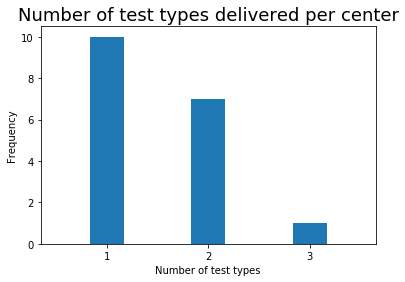

In [19]:
fig, ax = plt.subplots()
centers_ordered_by_test_types['nb of test types'].hist(range=(0.5, 3.5), bins=9);
ax.set_title("Number of test types delivered per center", fontsize=18);
ax.set_xlabel("Number of test types");
ax.set_xticks([1, 2, 3]);
ax.set_ylabel("Frequency");
ax.grid();

### Order centers by number of records

We can sort the centers by the number of records:

In [20]:
centers_ordered_by_records = df.groupby('id')['test type'].count().reset_index().sort_values(
    ['test type', 'id']).rename(
    index=str, columns={'id': 'center id', 'test type': 'nb of records'}
).set_index("center id")
centers_ordered_by_records

,nb of records
center id,
10254,25479
10336,32729
10299,34530
10294,40068
10301,49209
10138,118360
10263,157930
10341,179054
10449,212447


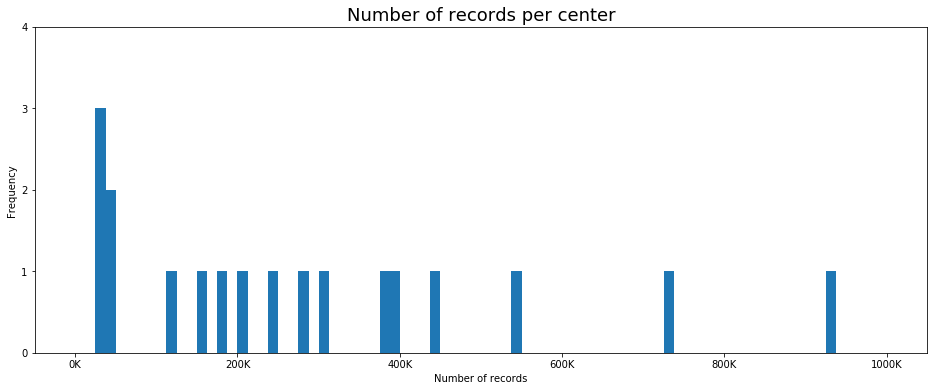

In [21]:
fig, ax = plt.subplots(figsize=(16, 6))
centers_ordered_by_records['nb of records'].hist(ax=ax, range=(0, 1*1e6), bins=80);
ax.set_title("Number of records per center", fontsize=18);
ax.set_xlabel("Number of records");
ax.set_xticklabels(["{0}K".format(int(x//1e3)) for x in ax.get_xticks()])
ax.set_ylabel("Frequency");
ax.set_yticks(range(5))
ax.grid();

We can combine these two in a new dataframe:

In [22]:
grouped_cid = df.groupby('id')
df1 = grouped_cid['test type'].nunique().reset_index()
df1['count'] = grouped_cid['test type'].count().reset_index()['test type']

df1.sort_values(by=['test type', 'count']).rename(
    index=str, columns={'id': 'center id', 'test type': 'nb of test types', 'count': 'nb of records'}
).set_index("center id")

,nb of test types,nb of records
center id,,
10254,1,25479
10336,1,32729
10299,1,34530
10294,1,40068
10301,1,49209
10138,1,118360
10341,1,179054
10449,1,212447
10137,1,249141


---
## Visualization: schedule

Plot available `appointment`s at all `grab` timestamps for center `10254` and test type `Blood Test`:

(<matplotlib.axes._subplots.AxesSubplot at 0x1203d3320>, None)

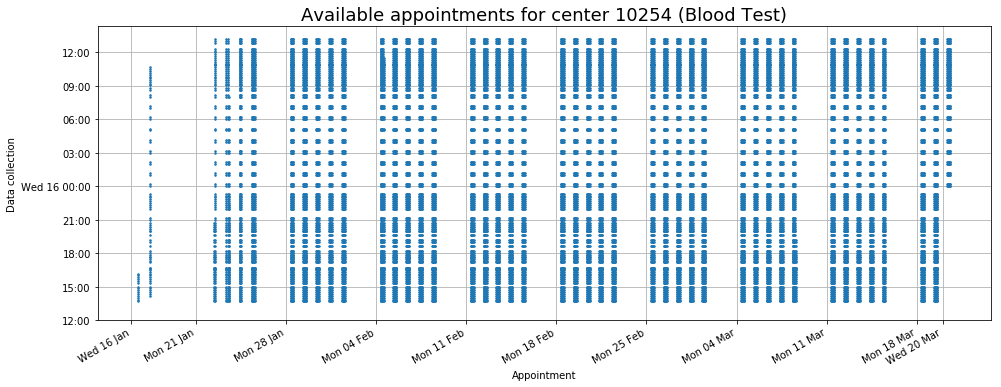

In [23]:
UHCW_plot(filter_center(df, center_id=10254, test_type="Blood Test").loc[:, ['id', 'test type', 'appointment', 'grab']])

In [24]:
%%time
print(datetime.datetime.now().strftime("%H:%M:%S"))
for center_id in center_test_types.index:
    break
    print("Center: {0}".format(center_id))
    for test_type in list(center_test_types.loc[center_id])[0]:
        print("Test type: {0}".format(test_type))
        ax, filepath = plot_center_schedule(
            df,
            center_id=center_id,
            test_type=test_type,
            x="appointment",
            y="grab", 
            x_freq="W",
            y_freq="H",
            savefigure=False
        );

11:30:52
CPU times: user 445 µs, sys: 164 µs, total: 609 µs
Wall time: 199 µs


---
## Times the appointments go online

Not all appointments in the future are accessible online at all times.  In this section of the notebook we will investigate how many days the appointments are posted ahead of time.

### Remark: dealing with artefacts
This is not merely a matter of curiosity.  Indeed, when we reconstruct the booking history of the appointments in notebook `UHCW_reconstruction.ipynb`, there will be artefacts if we do not account for the fact that only a finite number of appointments are visible on the portal.  Namely, we will erroneously interpret an appointment appearing on the dataset as an appointment having been cancelled and therefore become visible again on the chart.

### Main questions

1. Do all appointments on a new day go online at the same time?
1. If so, how many days ahead, and at what time?
1. Do all test centers follow the same rule?

### Timestamps of `first appearance`
We first look at the `grab` timestamp when each `appointment` appears in `df`.  Except for the very first results, this should indicate when the `appointment` first appeared online.

More precisely, we construct the dataframe `df_post_appt`, where we record the `first appearance` timestamp for each `appointment`.  This is the earliest `grab` timestamp where the `appointment` appears in the dataset.  (Here, by `appointment` we mean a timestamp at a specific center and for a specific test type.)

In [25]:
df_post_appt = df.groupby(['id', 'test type', 'appointment'])['grab'].min().to_frame()

df_post_appt.reset_index(inplace=True)

df_post_appt['appointment date'] = df_post_appt['appointment'].apply(lambda ts: ts.date())

df_post_appt.rename(index=str, columns={'grab': 'first appearance'}, inplace=True)
df_post_appt['first appearance date'] = df_post_appt['first appearance'].apply(lambda ts: ts.date())
df_post_appt['open window'] = df_post_appt['appointment date'] - df_post_appt['first appearance date']

In [26]:
df_post_appt.head()

,id,test type,appointment,first appearance,appointment date,first appearance date,open window
0,10136,Fasting Bloods,2019-01-17 07:20:00,2019-01-15 13:40:00,2019-01-17,2019-01-15,2 days
1,10136,Fasting Bloods,2019-01-17 07:25:00,2019-01-15 13:40:00,2019-01-17,2019-01-15,2 days
2,10136,Fasting Bloods,2019-01-17 07:30:00,2019-01-15 13:40:00,2019-01-17,2019-01-15,2 days
3,10136,Fasting Bloods,2019-01-17 07:35:00,2019-01-15 13:40:00,2019-01-17,2019-01-15,2 days
4,10136,Fasting Bloods,2019-01-17 07:40:00,2019-01-15 13:40:00,2019-01-17,2019-01-15,2 days


We generate a column with the `appointment date` since we expect that all appointments on a new appointment date go online at the same time, and the `open window` column records the number of days the `first appearance` occurs before the `appointment date`.  

We observe that for most appointment *dates*, there is only one `first appearance` timestamp:

In [27]:
df_post_appt.groupby(
    ['id', 'test type', 'appointment date'])['first appearance'].nunique(
).to_frame(
)['first appearance'].value_counts().to_frame().rename_axis(
    "nb of first appearance timestamps on a given day"
).rename(index=str, columns={"first appearance": "nb of occurrences"})

,nb of occurrences
nb of first appearance timestamps on a given day,
1,1354
2,19
3,4
4,3
8,2
9,1
5,1


In fact, given the size of `df_post_appt`, there are few distinct `first appearance` timestamps:

In [28]:
df_post_appt['first appearance'].nunique()

36

Let's look at the top 5 most occurring `first appearance` timestamps:

In [29]:
df_post_appt['first appearance'].value_counts()[0:5].to_frame().rename_axis(
"first appearance timestamp"
).rename(index=str, columns={'first appearance': "nb of occurrences"})

,nb of occurrences
first appearance timestamp,
2019-01-15 13:40:00,53761
2019-01-16 00:00:00,660
2019-01-15 14:50:00,288
2019-01-16 08:00:00,7
2019-01-16 09:50:00,6


The most occurring timestamp corresponds to the first `grab` timestamp in the dataframe `df`:

In [30]:
df['grab'].min()

Timestamp('2019-01-15 13:40:00')

We will ignore this timestamp since it most likely is an artefact of the data collection having to start when the system is already in place.  

### Classifying centers by `first appearance` timestamps
We record the two most occurring `first appearance` timestamps:

In [31]:
new_posting_timestamp_1 = df_post_appt['first appearance'].value_counts().index[1]
new_posting_timestamp_2 = df_post_appt['first appearance'].value_counts().index[2]

Next we look at the test centers with these `first appearance` values appearing in their data:

These two timestamps split the centers into two disjoint subsets:

In [32]:
df_centers_1 = df_post_appt[df_post_appt['first appearance'] == new_posting_timestamp_1]['id'].drop_duplicates().to_frame().reset_index(drop=True)
df_centers_2 = df_post_appt[df_post_appt['first appearance'] == new_posting_timestamp_2]['id'].drop_duplicates().to_frame().reset_index(drop=True)

pd.merge(df_centers_1, df_centers_2, how='inner', on='id')

,id


The resulting dataframe is empty, showing that the two sets are disjoint.

### Appointments with most occurring `first appearance` timestamp

The next most occuring `first appearance` timestamp falls at midnight:

In [33]:
new_posting_timestamp_1

Timestamp('2019-01-16 00:00:00')

  This strongly suggests that all appointments on a new day go online at midnight a certain number of days ahead (which we will calculate later).  
  
We test this conjecture by looking at the dates of the appointments for which this is indeed the first appearance:

In [34]:
df_post_appt[df_post_appt['first appearance'] == new_posting_timestamp_1].groupby(
    ['id', 'test type'])['appointment date'].unique().to_frame()

appointment date
id    test type                                       
10188 Blood Test              [2019-01-16, 2019-03-09]
      INR Test                [2019-01-16, 2019-03-20]
10207 Blood Test                          [2019-03-20]
10243 Blood Test                          [2019-05-21]
      INR Test                            [2019-05-21]
10244 Blood Test                          [2019-04-11]
      INR Test                            [2019-04-11]
10250 Blood Test                          [2019-04-10]
      INR Test                            [2019-04-10]
10254 Blood Test                          [2019-03-20]
10263 Blood Test                          [2019-03-11]
10266 Blood Test                          [2019-04-11]
      INR Test                            [2019-04-11]
10299 Glucose Tolerance Test              [2019-05-21]
10301 Blood Test                          [2019-03-20]
10352 Blood Test                          [2019-04-11]
      INR Test                            [2019-04-11]
10449 Blood Test                          [2019-04-11]

A majority of the test centers (12 out of 18) appear in this table.
If we discard the appointments with a date `2019-01-16`, occurring soon after the start of data collection, all appointments in this table with a `first appearance` timestamp of `2019-01-16 00:00:00` are on the same day (taking each test center and test type individually).

This table also shows that the different test centers choose to open their appointments with a different number of days ahead of time.  

On the other hand, again ignoring the `first appearance` date of `2019-01-16`, all test centers, except center `10188`, choose to open their appointments for all test types at the same time.  This follows directly by inspection, or programmatically with:

In [35]:
df_post_appt[df_post_appt['first appearance'] == new_posting_timestamp_1].groupby(
    ['id'])['appointment date'].unique().to_frame()

,appointment date
id,
10188,"[2019-01-16, 2019-03-09, 2019-03-20]"
10207,[2019-03-20]
10243,[2019-05-21]
10244,[2019-04-11]
10250,[2019-04-10]
10254,[2019-03-20]
10263,[2019-03-11]
10266,[2019-04-11]
10299,[2019-05-21]


Let's look at the number of days the appointments are put online ahead of time.

In [36]:
df_open_window_1 = df_post_appt[df_post_appt['first appearance'] == new_posting_timestamp_1].groupby(
    ['id', 'test type'])['open window'].unique().to_frame()['open window'].apply(
    lambda ow: ow[-1]).to_frame()
df_open_window_1

open window
id    test type                         
10188 Blood Test                 52 days
      INR Test                   63 days
10207 Blood Test                 63 days
10243 Blood Test                125 days
      INR Test                  125 days
10244 Blood Test                 85 days
      INR Test                   85 days
10250 Blood Test                 84 days
      INR Test                   84 days
10254 Blood Test                 63 days
10263 Blood Test                 54 days
10266 Blood Test                 85 days
      INR Test                   85 days
10299 Glucose Tolerance Test    125 days
10301 Blood Test                 63 days
10352 Blood Test                 85 days
      INR Test                   85 days
10449 Blood Test                 85 days

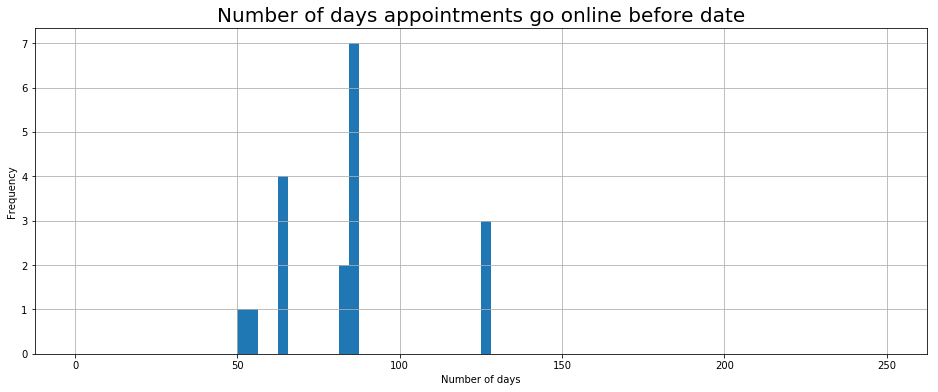

In [37]:
fig, ax = plt.subplots(figsize=(16, 6))
df_open_window_1['open window'].apply(lambda dt: dt.days).astype(int).hist(bins=80, range=(0, 250), ax=ax);
ax.set_title("Number of days appointments go online before date", fontsize=20)
ax.set_xlabel("Number of days");
ax.set_ylabel("Frequency");

### Appointments with next most occurring `first appearance` timestamp
We now perform the same analysis for the next most occurring `first appearance` timestamp:

In [38]:
new_posting_timestamp_2

Timestamp('2019-01-15 14:50:00')

The time of `14:50` is quite unusual.
Remember that the data was collected at discrete times:

In [39]:
df['grab'].unique()[6:9]

array(['2019-01-15T14:40:00.000000000', '2019-01-15T14:50:00.000000000',
       '2019-01-15T15:00:00.000000000'], dtype='datetime64[ns]')

Thus, the corresponding appointments have been posted any time between `14:40` and `14:50`.

As earlier, let's look at the appointment dates for which `new_posting_timestamp_2` is the `first appearance` timestamp:

In [40]:
df_post_appt[df_post_appt['first appearance'] == new_posting_timestamp_2].groupby(
    ['id', 'test type'])['appointment date'].unique().to_frame()

appointment date
id    test type                                   
10136 Fasting Bloods                  [2019-03-20]
      INR Test            [2019-01-16, 2019-04-04]
      Non Fasting Bloods  [2019-01-16, 2019-03-20]
10137 Blood Test                      [2019-05-03]
10138 Blood Test                      [2019-03-21]
10294 Blood Test                      [2019-03-20]
10341 Blood Test                      [2019-05-02]

We see that 5 out of remaining 6 test centers appear in this table.
Similar conclusions hold: ignoring the date of `2019-01-16`, for any given test center and test type, all appointments with a `first appearance` timestamp of `2019-01-15 14:50:00` occur on the same day.

Let's look at the number of days the appointments are put online ahead of time:

In [41]:
df_open_window_2 = df_post_appt[df_post_appt['first appearance'] == new_posting_timestamp_2].groupby(
    ['id', 'test type'])['open window'].unique().to_frame()['open window'].apply(
    lambda ow: ow[-1]).to_frame()
df_open_window_2

open window
id    test type                     
10136 Fasting Bloods         64 days
      INR Test               79 days
      Non Fasting Bloods     64 days
10137 Blood Test            108 days
10138 Blood Test             65 days
10294 Blood Test             64 days
10341 Blood Test            107 days

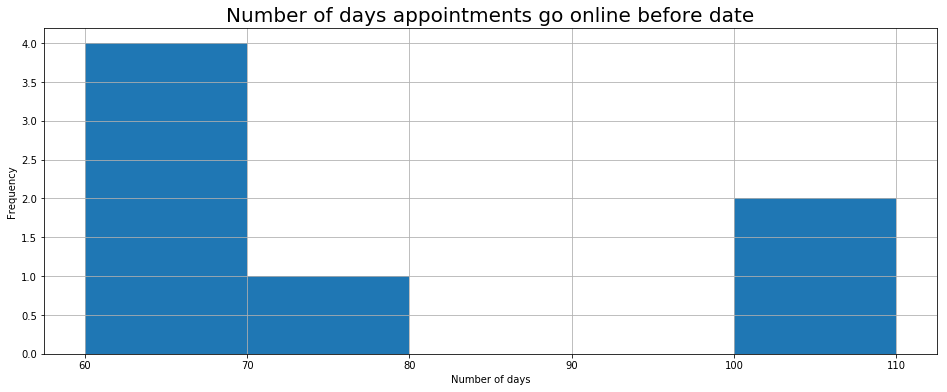

In [42]:
fig, ax = plt.subplots(figsize=(16, 6))
df_open_window_2['open window'].apply(lambda dt: dt.days).astype(int).hist(bins=5, range=(60, 110), ax=ax);
ax.set_title("Number of days appointments go online before date", fontsize=20)
ax.set_xlabel("Number of days");
ax.set_ylabel("Frequency");

### The remaining test center
Let's now find the remaining center:

In [43]:
all_centers = set(df['id'].values)
centers_1 = set(df_centers_1['id'])
centers_2 = set(df_centers_2['id'])
remaining_center = list(all_centers.difference(centers_1.union(centers_2)))[0]
remaining_center

10336

Let's look at its data.  We already know that it delivers one test type:

In [44]:
list(df[df['id'] == remaining_center]['test type'].unique())

['Blood Test']

Save it in a separate dataframe, for convenience:

In [45]:
df0 = df.loc[df['id'] == remaining_center, ['grab', 'appointment']].reset_index(drop=True)

We follow the procedure we used earlier for the entire dataframe `df`.
That is, we construct the dataframe `df0_post_appt`, where we record the `first appearance` timestamps of all appointments falling on the same day:

In [46]:
df0_post_appt = df0.groupby(['appointment'])['grab'].min().to_frame()

df0_post_appt.reset_index(inplace=True)

df0_post_appt['appointment date'] = df0_post_appt['appointment'].apply(lambda ts: ts.date())
df0_post_appt.rename(index=str, columns={'grab': 'first appearance'}, inplace=True)

<s>For this center, *all* appointments appeared in `df` at the same time:</s> true for small set

In [47]:
set(df0_post_appt['first appearance'])

{Timestamp('2019-01-15 13:40:00')}

---
## Visualization of last bookings

To finish this preliminary investigation of the dataset, we plot the *last* booking of the appointments for test center `10254`, which delivers only one type of blood test.

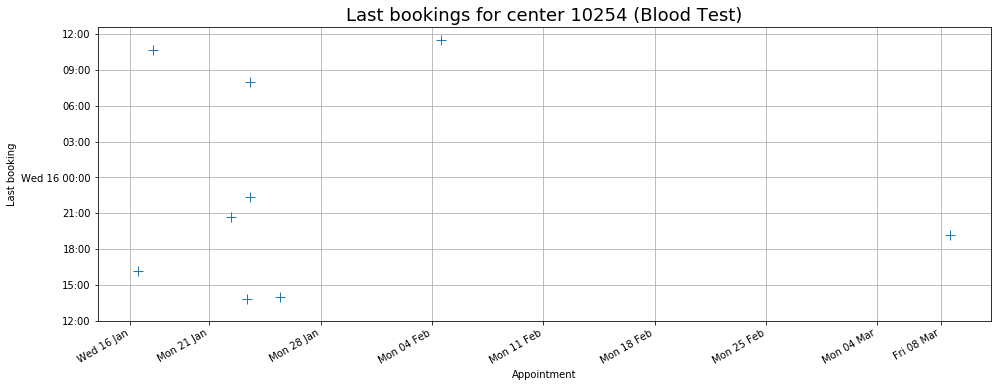

In [48]:
UHCW_plot(
    get_last_bookings(
        filter_center(
            df, center_id=10254, test_type="Blood Test"
        )
    ).loc[:, ['id', 'test type', 'appointment', 'last booking']],
    x_freq="W",
    y_freq="H",
    savefigure=False
);

This is far from satisfactory, though.  Booked appointments can be cancelled, thus resurfacing in the dataset, and rebooked again, thus disappearing again, and all this history is not visible in the above plot.
We will need more sophisticated processing to reconstruct the exact booking history of all appointments.
This we will do in the separate notebook `UHCW_reconstruction.ipynb`.

Record time of end of script:

In [49]:
end_script = datetime.datetime.now()

run_time = end_script - beg_script
run_time

datetime.timedelta(seconds=16, microseconds=779985)

In [50]:
print("This script ran for: {0}min {1}sec.".format(run_time.seconds//60, run_time.seconds%60))

This script ran for: 0min 16sec.
